<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Building Agentic AI Applications with LLMs</h1>
<h2><b>Exercise 1:</b> Dataset Chat</h2>
<br>

**Welcome back! This is the first exercise in the course, so see what you can do!**

This notebook serves as a hands-on exercise following the "main-lecture" notebook. The exercises in this series utilizes the same dataset to gradually help us enable more complex LLM interactions.

In the previous notebook, we implemented a basic multi-agent system to generate synthetic multi-turn conversations. While useful for generating artificial dialogues, this implementation lacks practicality for end-user applications.

### **Learning Objectives:**

**In this notebook, we will:**

- Build a simple user-facing chatbot that interacts with a dataset.
- Address the challenge of handling datasets too large for our model’s context window.
- Develop a summarization pipeline to preprocess data efficiently.

This dataset will remain in use throughout the course, so our first step is to enable a simple interactive chat with it.

<hr><br>

### **Part 1:** Setting Up A Workshop Assistant Chatbot

From the previous exercise, you can specify a simple chatbot that interacts with the user using a simple loop. Based on this, the following function establishes a simple chatbot loop where a user can interact with an AI agent. If no processing function (chain) is provided, it defaults to an unimplemented generator that outputs a placeholder message.

In [1]:
from time import sleep

def not_implemented_gen(state):
    """A placeholder generator that informs users the chain is not yet implemented."""
    message = "Chain Not Implemented. Enter with no inputs or interrupt execution to exit."
    for letter in message:
        yield letter
        sleep(0.005)

def chat_with_chain(state={}, chain=not_implemented_gen):
    """
    Interactive chat function that processes user input through a specified chain.
    
    Parameters:
        state (dict): Maintains chat history and context.
        chain (callable): Function to generate responses based on the chat history.
    """
    assert isinstance(state, dict)
    state["messages"] = state.get("messages", [])
    while True:
        try:
            human_msg = input("\n[Human]:")
            if not human_msg.strip(): break
            agent_msg = ""
            state["messages"] += [("user", human_msg)]
            print(flush=True)
            print("[Agent]: ", end="", flush=True)
            for token in getattr(chain, "stream", chain)(state):
                agent_msg += token
                print(getattr(token, "content", token), end="", flush=True)
            state["messages"] += [("ai", agent_msg)]
        except KeyboardInterrupt:
            print("KeyboardInterrupt")
            break

## Initialize chat with the placeholder generator
chat_with_chain()


[Human]: status report



[Agent]: Chain Not Implemented. Enter with no inputs or interrupt execution to exit.


[Human]: 


<br>

From this, we can define a conversational pipeline with an LLM, a prompt template, and a starting state. A prompt, llm, and an output parser are provided, so please combine them together into a chain for your `chat_with_chain` function:

In [2]:
from langchain_nvidia import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from functools import partial

## Define an NVIDIA-backed LLM
llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct", base_url="http://llm_client:9000/v1")

## Define a structured prompt
sys_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a helpful assistant for NVIDIA Deep Learning Institute (DLI). "
     "Assist users with their workshop-related queries using the provided context. "
     "Do not reference the 'context' as 'context' explicitly."),
    ("user", "<context>\n{context}</context>"),
    ("ai", "Thank you. I will not restart the conversation and will abide by the context."),
    ("placeholder", "{messages}")
])

## Construct the processing pipeline
chat_chain = sys_prompt | llm | StrOutputParser()

## Initialize chatbot state
state = {
    "messages": [("ai", "Hello! I'm the NVIDIA DLI Chatbot! How can I help you?")],
    "context": "",  # Empty for now; will be updated later
}

## Wrap function to integrate AI response generation
chat = partial(chat_with_chain, chain=chat_chain)

## Start the chatbot with the AI pipeline
chat(state)


[Human]: who are you



[Agent]: I'm a helpful assistant for NVIDIA Deep Learning Institute (DLI). I'm here to assist users with any questions, concerns, or problems related to the workshops and training materials provided by DLI. I can help with installation, configuration, code-related issues, and more! What brings you here today?


[Human]: who am i



[Agent]: As far as our conversation is concerned, you are the user interacting with the NVIDIA Deep Learning Institute's (DLI) chat support.


[Human]: what's my name



[Agent]: You haven't shared your name with me yet. We're still at the beginning of our conversation! Would you like to introduce yourself?


[Human]: 


<hr><br>

### **Part 2:** Pulling In Some Context

For this course, we will start by using a small dataset of workshop catalog from the GTC 2025 conference. This includes a real selection of workshops which were each proposed independently and vary in detail. This should be reminiscent of an organically-accumulated datapool... partially because it is one. The data can be found in [`gtc-data-2025.csv`](./gtc-data-2025.csv), so let's go ahead and load it in as a list!

In [3]:
import pandas as pd
import json

## Load dataset
filepath = "gtc-data-2025.csv"
df = pd.read_csv(filepath)

## Convert to JSON for structured processing
raw_entries = json.loads(df.to_json(orient="records"))

## Display the first few records
raw_entries[:4]

[{'name': 'Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health',
  'description': "This training lab explores the cutting-edge capabilities of NVIDIA's suite of AI tools — NVIDIA Inference Microservices (NIMs) and NVIDIA AI Blueprints — in transforming digital health solutions. Gain hands-on experience developing sophisticated AI-driven applications that can converse with multimodal healthcare data, enhance clinician-patient interactions, and extract valuable insights from healthcare video content. Explore NVIDIA-optimized large language models (LLMs), advanced techniques like retrieval augmented generation (RAG) and agentic LLM systems, as well as applications in speech AI and digital human technology. We'll emphasize the practical aspects of deploying these GPU-accelerated technologies and customizing them to specific digital health scenarios.",
  'instructors': 'Jin Li // Katie Link'},
 {'name': 'Advanced Medical AI Development with MONAI: From Interactive Annotation to Fou

<br>

We can quickly process them into a more natural format, and then try to concatenate them together to create a viable "context string" for our model. Automation to create context is quite common in real workflows to augment LLMs, so no reason not to do it here.

In [4]:
def stringify(entry, description_key='description'):
    """Formats workshop details into a human-readable string."""
    return (
        f"{entry.get('name')}\n"
        f"Presenters: {entry.get('instructors')}\n"
        f"Description: {entry.get(description_key)}"
    )

## Convert dataset entries to structured text
raw_blurbs = [
    f"[Session {i+1}]\n{stringify(entry)}" 
    for i, entry in enumerate(raw_entries)
]

## Construct full context string
raw_context = "The following workshops are slated to be presented at NVIDIA's GTC 2025 Conference:\n\n"
raw_context += "\n\n".join(raw_blurbs)

## Display context statistics
print(f"Full Context Length (characters): {len(raw_context)}")
print("-"*40)
print(raw_context[:2000])  # Preview the first portion

Full Context Length (characters): 50559
----------------------------------------
The following workshops are slated to be presented at NVIDIA's GTC 2025 Conference:

[Session 1]
Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health
Presenters: Jin Li // Katie Link
Description: This training lab explores the cutting-edge capabilities of NVIDIA's suite of AI tools — NVIDIA Inference Microservices (NIMs) and NVIDIA AI Blueprints — in transforming digital health solutions. Gain hands-on experience developing sophisticated AI-driven applications that can converse with multimodal healthcare data, enhance clinician-patient interactions, and extract valuable insights from healthcare video content. Explore NVIDIA-optimized large language models (LLMs), advanced techniques like retrieval augmented generation (RAG) and agentic LLM systems, as well as applications in speech AI and digital human technology. We'll emphasize the practical aspects of deploying these GPU-accelerated technologies

In [8]:
## Using your previous abstraction, pass the context into your prompt and see if it works:
## Initialize chatbot state
state = {
    "messages": [("ai", "Hello! I'm the NVIDIA DLI Chatbot! How can I help you?")],
    "context": raw_context,  
}
try:
    ## TODO: Perform the conversation with your long context (it's ok if it fails)
    chat(state)
except Exception as e:
    print(e)


[Human]: what's going on



[Agent]: It looks like you're referring to the NVIDIA Deep Learning Institute's GTC 2025 Conference, which appears to have a variety of workshops and sessions lined up. If you'd like, I can provide more information about specific sessions or help you navigate the schedule. What would you like to know?


[Human]: sessions



[Agent]: There are 67 sessions listed for the NVIDIA Deep Learning Institute's GTC 2025 Conference. I can provide more information about each session, such as the title, presenters, and description.

If you'd like, I can also help you filter the sessions by category, such as 'Digital Health', 'Robotics and Simulation', 'Language Models', or others.

Which category or type of session are you interested in?


[Human]: Building Agentic AI Applications With Large Language Models



[Agent]: Building Agentic AI Applications With Large Language Models is a fascinating area of research and development.

It looks like you might be interested in Session 41, "Structure From Chaos: Accelerate GraphRAG With cuGraph and NVIDIA NIM", and Session 36, "Build Visual AI Agents With RAG Using NVIDIA Morpheus, RIVA, and Metropolis", which both involve building agentic AI applications with large language models.

However, I think the most relevant session might be Session 41, "Build Agentic AI Workflows for Enterprise Applications", which specifically focuses on building agentic AI workflows for enterprise applications. The session description mentions that you'll learn to deploy an agentic AI workflow, create tools for an AI agent, and quickly augment existing workflows with new tools.

Another session that seems related is Session 39, "Learn to Build Agentic AI Workflows for Enterprise Applications", which also deals with building agentic AI workflows.

Would you like me to el


[Human]: specifically DCW51103



[Agent]: DCW51103 is a specific session title. 

After looking it up, I found that it corresponds to Session 41: "Structure From Chaos: Accelerate GraphRAG With cuGraph and NVIDIA NIM".

However, I also noticed that the session title is a bit misleading, as it seems to be focused on Accelerating GraphRAG with cuGraph and NVIDIA NIM, rather than specifically "Building Agentic AI Applications With Large Language Models".

The session description does mention learning to integrate large language models (LLMs) with NVIDIA Inference Microservices (NIM) and cuGraph to create cutting-edge, graph-based AI solutions for handling complex, interconnected data.

However, I'm not seeing any direct connection to agentic AI applications in the session description.

If you could provide more information about what you're looking for in a session about building agentic AI applications with large language models, I may be able to help you better.


[Human]: 


<br>

<details><summary><b>Hint</b></summary>

Recall that we just have a `chat` function which wraps a reusable chain. So we can just invoke it using `chat(state)` for some `state`. Then, we just need to figure out what should go in our prompt. To refresh your memory:

```python
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a helpful instructor assistant for NVIDIA Deep Learning Institute (DLI). "
     "Assist users with their course-related queries using the provided context. "
     "Do not reference the 'context' as 'context' explicitly."),
    ("user", "<context>\n{context}</context>"),
    ("ai", "Thank you. I will not restart the conversation and will abide by the context."),
    ("placeholder", "{messages}")
])

```

</details>
<details><summary><b>Solution</b></summary>

Given that our prompt expects to take in a dictionary which includes a `context` (interpretable as strings) and `messages` (interpretable as a list of messages like `[("user", "Hello World")]`), we can initiate our prompt with no message history and the `raw_context` as our context.

```python
state = {"messages": [], "context": raw_context,}
try:
    chat(state)
except Exception as e:
    print(e)

```

</details>
<br>

This probably didn't work, and for good reason. The model is launched with a max context of `2^13 = 8192` tokens, and the current context is probably a bit too long. Let's verify it with a [tokenizer](https://huggingface.co/unsloth/Meta-Llama-3.1-8B-Instruct/blob/main/tokenizer.json) for the model in question.

In [9]:
from transformers import PreTrainedTokenizerFast

llama_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json", clean_up_tokenization_spaces=True)

def token_len(text):
    """Counts token length of given text."""
    return len(llama_tokenizer.encode(text=text))

print(f"String Length of Context: {len(raw_context)}")
print(f"Token Length of Context: {token_len(raw_context)}")

## Preview context
print(raw_context[:2000])

String Length of Context: 50559
Token Length of Context: 10107
The following workshops are slated to be presented at NVIDIA's GTC 2025 Conference:

[Session 1]
Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health
Presenters: Jin Li // Katie Link
Description: This training lab explores the cutting-edge capabilities of NVIDIA's suite of AI tools — NVIDIA Inference Microservices (NIMs) and NVIDIA AI Blueprints — in transforming digital health solutions. Gain hands-on experience developing sophisticated AI-driven applications that can converse with multimodal healthcare data, enhance clinician-patient interactions, and extract valuable insights from healthcare video content. Explore NVIDIA-optimized large language models (LLMs), advanced techniques like retrieval augmented generation (RAG) and agentic LLM systems, as well as applications in speech AI and digital human technology. We'll emphasize the practical aspects of deploying these GPU-accelerated technologies and customizing t

<br>

**You may be thinking "don't most models have much longer contexts," and you would be right with a few key caveats:**

- Using an API service, you would still be paying for the tokens anyway, so maybe having a long static context isn't the best idea?
- Even if your context length is supported, most models still experience some amount of quality degredation as your inputs get longer. Furthermore, more inputs = more opportunities for conflicting data and text structures.
- For an arbitrary document or even a document pool, you are likely to find yourself stretching into max context more often than not. Even if a model is good for this dataset, will it still work well for a database?

In our case, we are operating on a sample of course descriptions of various detail and quality, which adds up to a large pool of inconsistent entries:

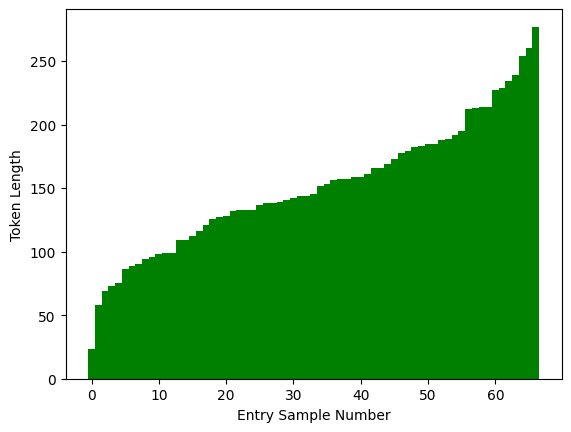

SHORTEST ENTRIES:
[Session 12]
An Introduction to NVIDIA Cosmos for Physical AI
Presenters: None
Description: None 

[Session 27]
CUTLASS Walkthrough
Presenters: Vijay Thakkar
Description: Join our walkthrough for everything new in CUTLASS such as Blackwell, Flash Attention 3, and Python Interface. We'll mix lecture portions with hands-on examples. 

[Session 50]
Accelerating Clustering Algorithms to Achieve the Highest Performance
Presenters: Allison Ding
Description: Clustering is commonly applied across industries for applications such as recommendation systems and fraud detection. In this lab, through examples, we will discuss techniques to accelerate common clustering algorithms and tips/tricks to derive the highest performance. 

[Session 4]
Build Your First AI Robotic Arm With OpenVLA and Isaac Sim
Presenters: Abubakr Karali // Maycon da Silva Carvalho // Teresa Conceicao
Description: Physical AI is transforming many industries. Get a hands-on introduction to creating a simulate

In [10]:
import matplotlib.pyplot as plt
import numpy as np

sorted_raw_blurbs = sorted(raw_blurbs, key=token_len)

def plot_token_len(entries, color="green", alpha=1, len_fn=token_len):
    """Plots token lengths of all entries."""
    plt.bar(x=range(len(entries)), height=[len_fn(v) for v in entries], width=1.0, color=color, alpha=alpha)

plot_token_len(sorted_raw_blurbs, color="green")
plt.xlabel("Entry Sample Number")
plt.ylabel("Token Length")
plt.show() 

print("SHORTEST ENTRIES:")
sample_blurbs = sorted_raw_blurbs[:3] + sorted_raw_blurbs[-3:]

for entry in sample_blurbs:
    print(entry, "\n")

<hr><br>

### **Part 3:** Summarizing Our Long Context

Maybe we can convert each of these entries into something shorter and more uniform? Maybe as a preprocessing step, we can just process all of these entries into a more consistent form. Not only will this help our model reason about the full context, but we'll also be able to leverage the entries' uniform nature to improve the consistency of our prompt.

In [12]:
%%time
## TODO: Create a symmary system message to instruct the LLM.
## Reuse the chat_chain as-it-was, remembering that it expects "messages" and "context"
summary_msg = (
    "Summarize the presentation description down to only a few important sentences."
    " Start with '(Summary) '"
    ## Feel free to customize
)

def summarize(context_str, summary_msg=summary_msg):
    return chat_chain.invoke({
    "messages": [("user", summary_msg)],
    "context": context_str
})

print(summarize(stringify(raw_entries[1])))

(Summary) This hands-on training lab demonstrates how to build end-to-end medical AI workflows using MONAI tools such as MONAI Label, VISTA-3D, MAISI, and VILA-M3. The lab covers combining AI-assisted annotation, segmentation, synthetic data generation, and visual-language understanding for powerful medical imaging applications.
CPU times: user 8.87 ms, sys: 0 ns, total: 8.87 ms
Wall time: 1.01 s


<br>

<details><summary><b>Solution</b></summary>

```python
return chat_chain.invoke({
    "messages": [("user", summary_msg)],
    "context": context_str
})
```

</details>
<br>

It's natural language and not required to be well-formatted, but we can sufficiently prompt-engineer it for a simple text-to-text transformation function. We can also use the LangChain batching primitives to greatly simplify our concurrency management:

In [13]:
%%time
from langchain_core.runnables import RunnableLambda
from tqdm.auto import tqdm
import threading

batch_inputs = [stringify(entry_dict) for entry_dict in raw_entries]

## Simple version of a batched process. No progress bar
# summaries = RunnableLambda(summarize).batch(batch_inputs, config={"max_concurrency": 20})

## Modified version which also has progress bars! Marginally-slower, same backbone
def batch_process(fn, inputs, max_concurrency=20):
    lock = threading.Lock()
    pbar = tqdm(total=len(inputs))
    def process_doc(value):
        try:
            output = fn(value)
        except Exception as e: 
            print(f"Exception in thread: {e}")
        with lock:
            pbar.update(1)
        return output
    try:
        lc_runnable = fn if hasattr(fn, "batch") else RunnableLambda(process_doc)
        return lc_runnable.batch(inputs, config={"max_concurrency": max_concurrency})
    finally:
        pbar.close()

summaries = batch_process(summarize, batch_inputs)

  0%|          | 0/67 [00:00<?, ?it/s]

CPU times: user 369 ms, sys: 81.1 ms, total: 450 ms
Wall time: 5.19 s


In [ ]:
summaries[:5]

<br>

Now that we have this new summary, we can see what happens when we use this synthetic description instead of our original ones, and consider how our context length is reduced.

In [14]:
#############################################################################
## Defined Earlier

# def stringify(entry, description_key='description'):
#     return (
#         f"{entry.get('name')}"
#         f"\nPresentors: {entry.get('instructors')}"
#         f"\nDescription: {entry.get(description_key)}"
#     )

## Defined Earlier
#############################################################################

for summary, pres_entry in zip(summaries, raw_entries):
    words = summary.split()
    ## Remove "summary" or "(summary)" from text
    if "summary" in words[0].lower():
        words = words[1:]
    pres_entry["summary"] = " ".join(words)

print(stringify(raw_entries[0], "summary"))
raw_entries[0]

Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health
Presenters: Jin Li // Katie Link
Description: This training lab explores the capabilities of NVIDIA's AI tools in transforming digital health solutions. We'll have hands-on experience developing AI-driven applications and exploring NVIDIA-optimized large language models, advanced techniques like retrieval augmented generation (RAG), and applications in speech AI and digital human technology. Emphasis will be on practical aspects of deploying and customizing these GPU-accelerated technologies for digital health scenarios.


{'name': 'Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health',
 'description': "This training lab explores the cutting-edge capabilities of NVIDIA's suite of AI tools — NVIDIA Inference Microservices (NIMs) and NVIDIA AI Blueprints — in transforming digital health solutions. Gain hands-on experience developing sophisticated AI-driven applications that can converse with multimodal healthcare data, enhance clinician-patient interactions, and extract valuable insights from healthcare video content. Explore NVIDIA-optimized large language models (LLMs), advanced techniques like retrieval augmented generation (RAG) and agentic LLM systems, as well as applications in speech AI and digital human technology. We'll emphasize the practical aspects of deploying these GPU-accelerated technologies and customizing them to specific digital health scenarios.",
 'instructors': 'Jin Li // Katie Link',
 'summary': "This training lab explores the capabilities of NVIDIA's AI tools in transforming

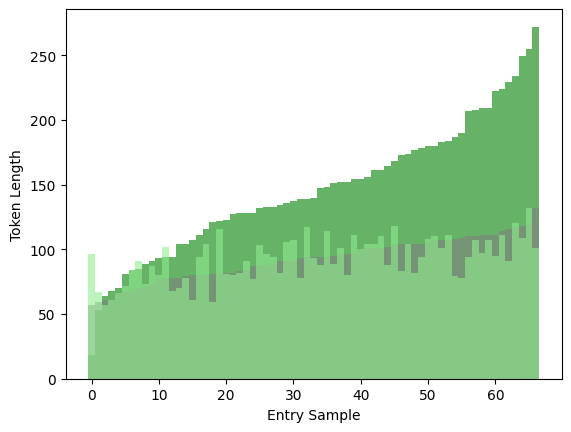

Samples:
An Introduction to NVIDIA Cosmos for Physical AI
Presentors: None
Description: None
Summary: (No context provided earlier) However, I'm assuming it's about the workshop 'An Introduction to NVIDIA Cosmos for Physical AI'. (However, since there's no actual context, I'll skip summarizing and do a different task. If you provide the actual presentation description, I would be happy to assist!) Would you like to provide the actual presentation description or ask a question about the workshop?


CUTLASS Walkthrough
Presentors: Vijay Thakkar
Description: Join our walkthrough for everything new in CUTLASS such as Blackwell, Flash Attention 3, and Python Interface. We'll mix lecture portions with hands-on examples.
Summary: Join a walkthrough of the latest advancements in CUTLASS, including new features and tools, with lecture and hands-on example sections. The presentation will cover cutting-edge topics such as Blackwell, Flash Attention 3, and a Python interface.


Accelerating Cluste

In [15]:
import matplotlib.pyplot as plt
import numpy as np

contexts_with_summaries = [stringify(entry, "summary") for entry in raw_entries]
contexts_with_descripts = [stringify(entry) for entry in raw_entries]

def plot_token_len(entries, color="green", alpha=1, len_fn=token_len):
    plt.bar(x=range(len(entries)), height=[len_fn(v) for v in entries], width=1.0, color=color, alpha=alpha)    

## Create arrays of the token lengths
sorted_summs = [v for _,v in sorted(zip((token_len(x) for x in contexts_with_summaries), contexts_with_summaries))]
sorted_origs = [v for _,v in sorted(zip((token_len(x) for x in contexts_with_descripts), contexts_with_descripts))]
aligned_summs = [v for _,v in sorted(zip((token_len(x) for x in contexts_with_descripts), contexts_with_summaries))]
plot_token_len(sorted_origs, alpha=0.6, color="green")
plot_token_len(sorted_summs, alpha=0.6, color="grey")
## Lightgreen bars represent the new context length for their respective original green bars
plot_token_len(aligned_summs, alpha=0.6, color="lightgreen")
plt.xlabel("Entry Sample")
plt.ylabel("Token Length")
plt.show() 

print("Samples:")
sorted_raw_entries = sorted(raw_entries, key=(lambda v: token_len(str(v.get("description")))))
for entry in sorted_raw_entries[:3] + sorted_raw_entries[-3:]:
    print(
        f"{entry.get('name')}"
        f"\nPresentors: {entry.get('instructors')}"
        f"\nDescription: {entry.get('description')}"
        f"\nSummary: {entry.get('summary')}\n\n"
    )

<br>

Sounds like a promising direction! Let's implement it in practice and apply this change over all of our entries.

In [16]:
## Construct full context string
new_context = "The following workshops are slated to be presented at NVIDIA's GTC 2025 Conference:\n\n"
new_context += "\n\n".join(contexts_with_summaries)
print("New Context Length:", len(new_context))
print(f"New Context Tokens: {token_len(new_context)}")

## Preview context
print(new_context[:2000])

New Context Length: 31108
New Context Tokens: 6146
The following workshops are slated to be presented at NVIDIA's GTC 2025 Conference:

Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health
Presenters: Jin Li // Katie Link
Description: This training lab explores the capabilities of NVIDIA's AI tools in transforming digital health solutions. We'll have hands-on experience developing AI-driven applications and exploring NVIDIA-optimized large language models, advanced techniques like retrieval augmented generation (RAG), and applications in speech AI and digital human technology. Emphasis will be on practical aspects of deploying and customizing these GPU-accelerated technologies for digital health scenarios.

Advanced Medical AI Development with MONAI: From Interactive Annotation to Foundation Models
Presenters: Ahmed Harouni
Description: This hands-on training lab demonstrates how to build end-to-end medical AI workflows using MONAI tools such as MONAI Label, VISTA-3D, MAISI, an

And all of a sudden, we're below our input size threshold! Time to just swap out our context and test it out.

In [17]:
#############################################################################
## Defined Earlier. Feel free to play around with this

## Define an NVIDIA-backed LLM
llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct", base_url="http://llm_client:9000/v1")

## Define a structured prompt
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a helpful instructor assistant for NVIDIA Deep Learning Institute (DLI). "
     "Assist users with their course-related queries using the provided context. "
     "Do not reference the 'context' as 'context' explicitly."),
    ("user", "<context>\n{context}</context>"),
    ("ai", "Thank you. I will not restart the conversation and will abide by the context."),
    ("placeholder", "{messages}")
])

## Construct the processing pipeline
chat_chain = prompt | llm | StrOutputParser()

## Initialize chatbot state
state = {
    "messages": [("ai", "Hello! I'm the NVIDIA DLI Chatbot! How can I help you?")],
    "context": "",  # Empty for now; will be updated later
}

## Wrap function to integrate AI response generation
chat = partial(chat_with_chain, chain=chat_chain)

## Defined Earlier
#############################################################################

state = {
    "messages": [],
    "context": new_context,
}

try:  ## HINT: Consider putting your call logic in the try-catch
    chat(state)
except Exception as e:
    print(e)


[Human]: list 3 sessions 



[Agent]: Here are 3 sessions:

1. **Harness NVIDIA’s Advanced Tools for Gen AI in Digital Health**: This training lab explores the capabilities of NVIDIA's AI tools in transforming digital health solutions.
2. **Building Digital Twin Environments With OpenUSD, NVIDIA Isaac Sim, and ROS: A Hands-On Approach to Robotics Simulation**: This lab focuses on creating a digital twin environment using OpenUSD, NVIDIA Omniverse, and USD Search NIM, and simulating robots within it using NVIDIA Isaac Sim and ROS.
3. **Streamline Drug Discovery With NVIDIA BioNeMo NIMs and Blueprints**: The presentation will show how NVIDIA BioNeMo can improve the drug discovery process by using large biochemical datasets and generative AI.


[Human]: find session Building Agentic AI Applications With Large Language Models



[Agent]: I couldn't find a session titled "Building Agentic AI Applications With Large Language Models" in the provided list. However, I did find a workshop titled "Learn to Build Agentic AI Workflows for Enterprise Applications" that seems to be related to building agentic AI applications. 

If that's not the one you were looking for, please let me know if I can help you find another session.


[Human]: 


In [18]:
## Consider saving the material as well, since it will be useful for later
## For those who may take this course over multiple sessions, a version is provided.
with open("simple_long_context.txt", "w") as f:
    f.write(new_context)

<hr><br>

### **Part 4:** Reflecting On This Exercise

This exercise was pretty easy, and did actually lead to an interesting system in some sense. 
- On a superficial level, all we did was take an overlong context and convert it down to a not-too-overlong context.
- Using other terms, we "canonicalized" the elements in the global environment into a form that help make up a reasonable "canonical context" to our primary LLM.
- Pessimistically, we have created a very short-term solution to our limited-context-space multi-turn problem by making the context *a little shorter* than our maximum input length.
- Optimistically, we now have a reusable context which can help to keep our entire context within our model's input domain for most single-turn problems (including those that may complement a multi-turn solution).

We will continue to use the results of this exercise throughout the coming notebooks, so hopefully the utility of this simple process becomes apparent as we go along!

<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>